![Semillero Astrofisica](../logo.PNG)

---
# **Ecuacion diferencial ordinaria de orden superior**

David Felipe Bambague (dbambague@unal.edu.co)

Carlos Andrés del Valle (cdelv@unal.edu.co)

---

  Vamos a resolver la ecuación difrerncial de una viga en cantilever.

  \begin{equation*}
      EI\frac{d^4\eta}{dx^4}=0
  \end{equation*}

  con $E=1$, $F=3$ y $I=1$. Las condiciones de frontera del problema son:

  \begin{equation*}
      \eta(0)=0\\
      \eta^{\prime}(0)=0\\
      \eta^{\prime\prime}(L)=0\\
      \eta^{\prime\prime\prime}(L)=\frac{F}{EI}
  \end{equation*}
  
  La solución analítica de esta ecuación es
    \begin{equation*}
      \eta(x)=\frac{Fx^2(x-3L)}{6EI}
  \end{equation*}

In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

#Usar doble precisión si la GPU lo soporta. Float32 por defecto.
dde.config.real.set_float64()

Using backend: tensorflow.compat.v1

2022-10-21 13:56:57.384231: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-21 13:56:57.387100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 13:56:57.387109: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2022-10-21 13:56:58.578714: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-21 13:56:58.578750: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


## 1. Definir la Ecuación a Resolver

In [2]:
I=1.0
F=3.0
E=1.0
L=1

def ode1(x, y):
    dy_dt = dde.grad.jacobian(y, x)
    d2y_dt2 = dde.grad.hessian(y, x)
    d3y_dt3 =dde.grad.jacobian(d2y_dt2,x)
    d4y_dt4 = dde.grad.hessian(d2y_dt2, x)
    return E*I*d4y_dt4 

def func(x):
    return F*x**2*(x-3*L)/(6*E*I)

## **2. Definir Dominio de la Ecuación**

In [3]:
geom = dde.geometry.TimeDomain(0, L)

## **3. Definir Condiciones Iniciales y de Frontera**

In [4]:
def IC_1(x):
    return 0 

def IC_2(inputs, outputs, x):
    return dde.grad.jacobian(outputs, inputs)-0

def IC_3(inputs, outputs, x):
    return dde.grad.hessian(outputs, inputs)-0

def IC_4(inputs, outputs, x):
    dy_dx = dde.grad.jacobian(outputs, inputs)
    return dde.grad.hessian(dy_dx, inputs)-F/(E*I)

IC1 = dde.icbc.IC(geom,         IC_1, lambda x, on_initial: on_initial)
IC2 = dde.icbc.OperatorBC(geom, IC_2, lambda x, on_initial: on_initial)
IC3 = dde.icbc.OperatorBC(geom, IC_3, lambda x, on_initial: np.isclose(x[0], L))
IC4 = dde.icbc.OperatorBC(geom, IC_4, lambda x, on_initial: np.isclose(x[0], L))

## **4. Crear Datos de Entrenamiento**

In [5]:
data1 = dde.data.TimePDE(geom, ode1, [IC1,IC2, IC3, IC4], 62, 4, solution=func)

## **5. Crear la Red Neuronal**

In [6]:
layer_size = [1] + [30]*3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net1 = dde.nn.FNN(layer_size, activation, initializer)

## **6. Compilar y Entrenar el Modelo**

In [7]:
# Modelo
model1 = dde.Model(data1, net1)

# Optimizador L-BFGS-B
dde.optimizers.config.set_LBFGS_options(maxiter=5000)

model1.compile("L-BFGS")
losshistory1, train_state1 = model1.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.034172 s



/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-10-21 13:56:59.995560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 1.455458 s

Initializing variables...
Training model...



2022-10-21 13:57:01.452154: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Step      Train loss                                            Test loss                                             Test metric
0         [9.24e-01, 0.00e+00, 4.04e-01, 1.12e-01, 9.92e+00]    [9.24e-01, 0.00e+00, 4.04e-01, 1.12e-01, 9.92e+00]    []  
1000      [2.58e-03, 5.30e-12, 2.73e-01, 5.11e-02, 1.28e-02]                                                              
2000      [2.58e-03, 1.41e-10, 2.73e-01, 5.11e-02, 1.28e-02]                                                              
3000      [2.58e-03, 3.44e-10, 2.73e-01, 5.11e-02, 1.28e-02]                                                              
4000      [2.59e-03, 1.78e-10, 2.73e-01, 5.11e-02, 1.28e-02]                                                              
5000      [2.60e-03, 5.96e-12, 2.73e-01, 5.11e-02, 1.28e-02]                                                              
6000      [2.60e-03, 7.82e-15, 2.73e-01, 5.11e-02, 1.28e-02]                                                              
INFO:tens

## 7. Visualizar la solución

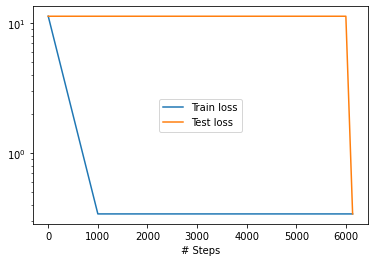

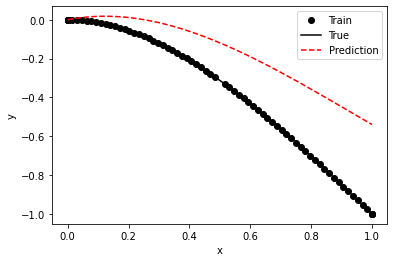

In [8]:
dde.saveplot(losshistory1, train_state1, issave=False, isplot=True) 

## Cómo Mejorar esta Solución? Hay que Partir la Ecuación

Creamos un sistema de ecuaciones de la siguiente manera

\begin{equation}
    \begin{split}
        & y^\prime=A \\
        & y^{\prime\prime} = A^\prime \qquad A^\prime=B \\
        & y^{\prime\prime\prime} = B^\prime \qquad B^\prime=C \\
        & y^{\prime\prime\prime\prime} = C^\prime \\
    \end{split}
\end{equation}

Entonces la ecuación
  \begin{equation*}
      EI\frac{d^4\eta}{dx^4}=0
  \end{equation*}

Se puede escribir como 
\begin{equation}
    \begin{split}
        & A-y^\prime=0 \\
        & B-A^\prime=0 \\
        & C-B^\prime=0 \\
        & EIC^\prime=0 \\
    \end{split}
\end{equation}

In [9]:
def ode2(x, y):
    Y, A, B, C = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:]
    dy_dx = dde.grad.jacobian(y, x, i=0)
    dA_dx = dde.grad.jacobian(y, x, i=1)
    dB_dx = dde.grad.jacobian(y, x, i=2)
    dC_dx = dde.grad.jacobian(y, x, i=3)
    return [A-dy_dx, 
            B-dA_dx, 
            C-dB_dx,
            E*I*dC_dx,
           ]

## Condiciones de Frontera

In [10]:
IC1 = dde.icbc.IC(geom, lambda x: 0      , lambda x, on_initial: on_initial,          component=0) # Y
IC2 = dde.icbc.IC(geom, lambda x: 0      , lambda x, on_initial: on_initial,          component=1) # A = Y'
IC3 = dde.icbc.IC(geom, lambda x: 0      , lambda x, on_initial: np.isclose(x[0], L), component=2) # B = Y''
IC4 = dde.icbc.IC(geom, lambda x: F/(E*I), lambda x, on_initial: np.isclose(x[0], L), component=3) # C = Y'''

## Datos de Entrenamiento

In [11]:
data2 = dde.data.TimePDE(geom, ode2, [IC1,IC2, IC3, IC4], 62, 8, num_test=0)

## Red Neuronal

In [12]:
layer_size = [1] + [30]*3 + [4]
activation = "tanh"
initializer = "Glorot uniform"
net2 = dde.nn.FNN(layer_size, activation, initializer)

## Compilar y Entrenar la Red

In [13]:
# Modelo
model2 = dde.Model(data2, net2)

# Optimizador L-BFGS-B
dde.optimizers.config.set_LBFGS_options(maxiter=5000)

model2.compile("L-BFGS")
losshistory2, train_state2 = model2.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.040022 s

'compile' took 0.298245 s

Initializing variables...
Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [2.61e-02, 5.56e-03, 2.45e-02, 1.96e-02, 0.00e+00, 0.00e+00, 6.67e-03, 8.18e+00]    [nan, nan, nan, nan, 0.00e+00, 0.00e+00, 6.67e-03, 8.18e+00]                        []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  Objective function value: 0.000000
  Number of iterations: 722
  Number of functions evaluations: 776
776       [1.07e-10, 1.23e-10, 5.28e-12, 4.60e-11, 1.57e-18, 1.94e-18, 3.37e-18, 7.73e-19]    [nan, nan, nan, nan, 1.57e-18, 1.94e-18, 3.37e-18, 7.73e-19]                        []  

Best model at step 776:
  train loss: 2.81e-10
  test loss: nan
  test metric

## Visualizar la solución

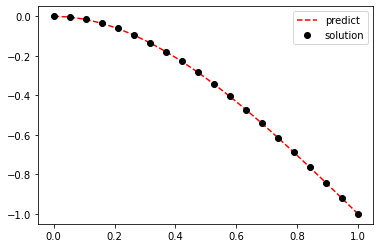

In [15]:
x = geom.uniform_points(20)
y = model2.predict(x)
dde.utils.external.plot_loss_history(losshistory2)

plt.figure()
plt.plot(x,y[:,0],'--',color='red',label='predict')
plt.plot(x,func(x),'o',color='black',label='solution')
plt.legend()
plt.show()